##**Create Block and Nets**

In [ ]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# imports
import torch.nn as nn
import torch.nn.functional as F
import scipy
import pandas as pd
import numpy as np
import wfdb
import ast
import torch
import time
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim


In [ ]:
# load drive 
from google.colab import drive 
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("drive/My Drive/")

FileNotFoundError: ignored

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
%matplotlib inline


Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y

  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the p

In [ ]:

# !wget -r -N -c -np https://physionet.org/files/challenge-2018/1.0.0/

In [ ]:
!ls

## Network blocks

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self,input_dim,output_dim,kernel,max_pool):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, output_dim, kernel_size=(kernel))
        self.BN = nn.BatchNorm1d(output_dim)
        self.MP = nn.MaxPool1d(max_pool)
        

    def forward(self, x):
        x = self.conv1(x)
        # print('conv',x)
        x = F.relu(self.BN(x))
        # print('relu+BN',x)
        x = self.MP(x)
        # print('MP',x)

        return x

In [ ]:
class SpatialBlock(nn.Module):
    def __init__(self,input_dim,output_dim,kernel,max_pool):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, output_dim, kernel_size=(kernel))
        self.BN = nn.BatchNorm1d(output_dim)
        self.MP = nn.MaxPool1d(max_pool)
        

    def forward(self, x):
        x = self.conv1(x)
        
        x = F.relu(self.BN(x))
        
        x = self.MP(x)
        

        return x

In [ ]:
class FCBlock(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.FC = nn.Linear(input_dim, output_dim)
        self.BN = nn.BatchNorm1d(output_dim)
        

    def forward(self, x):
        x = self.FC(x)
        x = F.relu(self.BN(x))
        x = F.dropout(x)

        return x

In [ ]:
class SexNet(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.Temp1 = TemporalBlock(12,16,7,2)
        self.Temp2 = TemporalBlock(16,16,5,4)
        self.Temp3 = TemporalBlock(16,32,4,2)
        self.Temp4 = TemporalBlock(32,32,5,4)
        self.Temp5 = TemporalBlock(32,64,5,2)
        self.Temp6 = TemporalBlock(64,64,3,2)
        self.Temp7 = TemporalBlock(64,64,3,2)
        self.Temp8 = TemporalBlock(64,64,3,1)
        self.Spat = SpatialBlock(5,128,12,2)
        self.FC1 =  FCBlock(128*26,128)
        self.FC2 =  FCBlock(128,64)
        self.out = nn.Linear(64,2)

    def forward(self, x):
        x = self.Temp1(x)
        x = self.Temp2(x)
        x = self.Temp3(x)
        x = self.Temp4(x)
        x = self.Temp5(x)
        x = self.Temp6(x)
        x = self.Temp7(x)
        x = self.Temp8(x)

        x = torch.swapaxes(x, 1,2)
        x = self.Spat(x)
        x = x.view(x.shape[0],-1)
        x = self.FC1(x)
        x = self.FC2(x)
        x = self.out(x)

        return x

In [ ]:
class AgeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Temp1 = TemporalBlock(12,16,7,2)
        self.Temp2 = TemporalBlock(16,16,5,4)
        self.Temp3 = TemporalBlock(16,32,4,2)
        self.Temp4 = TemporalBlock(32,32,5,4)
        self.Temp5 = TemporalBlock(32,64,5,2)
        self.Temp6 = TemporalBlock(64,64,3,2)
        self.Temp7 = TemporalBlock(64,64,3,2)
        self.Temp8 = TemporalBlock(64,64,3,1)
        self.Spat = SpatialBlock(5,128,12,2)

        self.FC1 =  FCBlock(128*26,128)
        self.FC2 =  FCBlock(128,64)
        self.out = nn.Linear(64,1)

    def forward(self, x):
        x = self.Temp1(x)
        x = self.Temp2(x)
        x = self.Temp3(x)
        x = self.Temp4(x)
        x = self.Temp5(x)
        x = self.Temp6(x)
        x = self.Temp7(x)
        x = self.Temp8(x)
        x = torch.swapaxes(x, 1,2)
        x = self.Spat(x)
        x = x.view(x.shape[0],-1)
        x = self.FC1(x)
        x = self.FC2(x)
        x = self.out(x)

        return x.squeeze()

In [ ]:
def writeCSVLoggerFile(csvLoggerFile_path,log):
    df = pd.DataFrame([log])
    # print(df)
    with open(csvLoggerFile_path, 'a') as f:
        df.to_csv(f, mode='a', header=f.tell() == 0, index=False)

### Load Data


In [ ]:
class ECGDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(
        self,
        df,
        sampling_rate,
        label_type, # sex/age
    ):
        self.df = df   
        self.sampling_rate = sampling_rate
        self.label_type = label_type
        self.test_fold = 10
        self.val_fol = 9
        

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, i: int):
          df = self.df.iloc[i]

          if self.sampling_rate == 100:
              data = wfdb.rdsamp(df.filename_lr) 
          else:
              data = wfdb.rdsamp(df.filename_hr)
          signal, _ = data
          data = np.array(signal)
          data_pad = np.zeros((data.shape[0]+120,data.shape[1]))
          data_pad[60:-60,:] = data
          signal = torch.Tensor(data_pad)

          if self.label_type == 'sex': 
              label = (df.sex)
          else:
              label = (df.age)
          return signal, label

In [ ]:
def load_raw_data(df, sampling_rate):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate=500

## According to the data ducomentation it's suggested to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

# Split data into train, validation and test
test_fold = 10
val_fold = 9 

# load and convert annotation data
Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')[:500]
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
Y = Y.dropna(subset=['sex', 'age'])

Y_train = Y[(((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)))]
Y_val = Y[(((Y.strat_fold == val_fold)))]
Y_test = Y[(((Y.strat_fold == test_fold)))]


dataset_train_sex = ECGDataset(Y_train, 500, 'sex')
train_dataloader_sex = DataLoader(dataset_train_sex , batch_size=16, shuffle=True,drop_last=True)
dataset_train_age = ECGDataset(Y_train, 500, 'age')
train_dataloader_age = DataLoader(dataset_train_age , batch_size=64, shuffle=True,drop_last=True)

dataset_val_sex = ECGDataset(Y_val, 500, 'sex')
val_dataloader_sex = DataLoader(dataset_val_sex , batch_size=16, shuffle=False,drop_last=True)
dataset_val_age = ECGDataset(Y_val, 500, 'age')
val_dataloader_age = DataLoader(dataset_val_age , batch_size=64, shuffle=False,drop_last=True)

dataset_test_sex = ECGDataset(Y_test, 500, 'sex')
test_dataloader_sex = DataLoader(dataset_test_sex , batch_size=16, shuffle=False,drop_last=True)
dataset_test_age = ECGDataset(Y_test, 500, 'age')
test_dataloader_age = DataLoader(dataset_test_age , batch_size=64, shuffle=False,drop_last=True)


training_log_age = {}
validaiting_log_age = {}
training_log_sex = {}
validaiting_log_sex = {}

In [ ]:
# # data analysis
# import matplotlib.pyplot as plt

# plt.hist(y_train_sex)
# plt.title('Train - sex')
# plt.show()

# plt.hist(y_train_age, bins=len(y_train_age) )
# plt.title('Train - age')
# plt.show()


# # sex=1, age distrebution
# y_sex1_age = torch.Tensor(Y[(((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold) & (Y.sex == 1)))].age.values)
# plt.hist(y_train_age, bins=len(y_sex1_age) )
# plt.title('Train - sex1_age')
# plt.show()

# # sex=0, age distrebution
# y_sex0_age = torch.Tensor(Y[(((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold) & (Y.sex == 0)))].age.values)
# plt.hist(y_train_age, bins=len(y_sex0_age) )
# plt.title('Train - sex0_age')
# plt.show()

In [ ]:
start_time = time.strftime("_%d_%m_%Y_%H_%M")
result_dir = '/content/drive/MyDrive/results_2' +'/' + start_time 
os.makedirs(result_dir, exist_ok=True)
writer = SummaryWriter(result_dir + '/' + 'tensor_logs')
save_each = 5
print(result_dir)

if not os.path.isdir(result_dir +'/Saved_age'+ '/Periodic_save'):
  os.makedirs(result_dir +'/Saved_age' +'/Periodic_save', exist_ok=True)

if not os.path.isdir(result_dir +'/Saved_age'+ '/Best_model_save'):
  os.makedirs(result_dir +'/Saved_age' +'/Best_model_save', exist_ok=True)
csvLoggerFile_path_train_age = os.path.join(result_dir, "history_train_age.csv")
csvLoggerFile_path_val_age = os.path.join(result_dir, "history_val_age.csv")
csvLoggerFile_path_train_sex = os.path.join(result_dir, "history_train_sex.csv")
csvLoggerFile_path_val_sex = os.path.join(result_dir, "history_val_sex.csv")


/content/drive/MyDrive/results_2/_09_06_2022_16_29


In [ ]:
age_net = AgeNet()
print(age_net)
sex_net = SexNet()
print(sex_net)
criterion_age = nn.MSELoss()
optimizer_age = optim.Adam(age_net.parameters(), lr=0.0003)

criterion_sex = nn.BCEWithLogitsLoss()
optimizer_sex = optim.Adam(sex_net.parameters(), lr=0.0003)


AgeNet(
  (Temp1): TemporalBlock(
    (conv1): Conv1d(12, 16, kernel_size=(7,), stride=(1,))
    (BN): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MP): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Temp2): TemporalBlock(
    (conv1): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
    (BN): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MP): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (Temp3): TemporalBlock(
    (conv1): Conv1d(16, 32, kernel_size=(4,), stride=(1,))
    (BN): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MP): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Temp4): TemporalBlock(
    (conv1): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (BN): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MP): MaxPool1d(kerne

In [ ]:
from tqdm import tqdm


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
validation_losses = []
age_net = age_net.to(device, non_blocking=True)


for epoch in range(20):  # loop over the dataset multiple times
    print (epoch)
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_dataloader_age, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data# next(iter(train_dataloader_age))
        # print('Before-',inputs)
        inputs = inputs.to(device, non_blocking=True, dtype=torch.float)
        labels = labels.to(device, non_blocking=True, dtype=torch.float)
        inputs = inputs.permute(0,2,1)
        # print('Aftre-',inputs)

        # zero the parameter gradients
        optimizer_age.zero_grad()

        # forward + backward + optimize
        outputs = age_net(inputs)
        # outputs[labels.isnan()]=0
        # labels[labels.isnan()]=0
        loss = criterion_age(outputs, labels)
        print('batch - {},loss -{}'.format(i,loss.item()))
        loss.backward()
        optimizer_age.step()

        # print statistics
        running_loss += loss.item()

    print(running_loss,i)
    print(f'epoch [{epoch}] - train_avg_loss: {running_loss / (i+1)}')
    writer.add_scalar("Train/Age_Loss", running_loss / (i+1), epoch)   
    training_log_age["epoch"] = epoch
    training_log_age["ave_loss"] = running_loss / (i+1)
    writeCSVLoggerFile(csvLoggerFile_path_train_age,training_log_age)
    with torch.no_grad():
            
        age_net.eval()
        val_loss = 0.0

        for i, val_data in enumerate(tqdm(val_dataloader_age,0)):

            inputs, labels = val_data
            inputs = inputs.to(device, non_blocking=True, dtype=torch.float)
            labels = labels.to(device, non_blocking=True, dtype=torch.float)
            inputs = inputs.permute(0,2,1)
            outputs = age_net(inputs)
            #print(labels, outputs)
            loss = criterion_age(outputs, labels)
            
            print("val_loss- {} ".format(loss.item()))
            val_loss += loss.item()

        validation_losses.append(val_loss)  

    print(f'epoch [{epoch }] - val_avg_loss: {val_loss / (i+1)}')
    writer.add_scalar("Validation/Age_Loss", val_loss / (i+1), epoch)
    validaiting_log_age["epoch"] = epoch
    validaiting_log_age["ave_loss"] = val_loss / (i+1)
    writeCSVLoggerFile(csvLoggerFile_path_val_age,validaiting_log_age)
    
    if epoch == 0:
        best_loss = val_loss
    print(best_loss)
    # save best model
    if epoch > 0  and validation_losses[-1] < best_loss:
        best_loss = validation_losses[-1]    
        print('save best')
        torch.save({
            'age_net': age_net.state_dict(),
            'optimizer_age': optimizer_age.state_dict(),
            'epoch': epoch+1},
            os.path.join(result_dir,'Saved_age','Best_model_save', f"AgeNet.pth"))              

    # save each % epoch 
    if epoch > 0  and epoch % save_each == 0:
        print('save epoch')
        torch.save({
            'age_net': age_net.state_dict(),
            'optimizer_age': optimizer_age.state_dict(),
            'epoch': epoch+1},
            os.path.join(result_dir,'Saved_age','Periodic_save', f"AgeNet.pth"))
        
torch.cuda.empty_cache()   
print('Finished Training')


0


100%|██████████| 5/5 [00:20<00:00,  4.11s/it]


14573.41162109375 4
epoch [0] - train_avg_loss: 2914.68232421875


100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


val_loss- 3055.808349609375 
epoch [0] - val_avg_loss: 3055.808349609375
3055.808349609375
1


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


14603.603515625 4
epoch [1] - train_avg_loss: 2920.720703125


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val_loss- 3043.141357421875 
epoch [1] - val_avg_loss: 3043.141357421875
3055.808349609375
save best
2


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


14248.96435546875 4
epoch [2] - train_avg_loss: 2849.79287109375


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


val_loss- 3023.306640625 
epoch [2] - val_avg_loss: 3023.306640625
3043.141357421875
save best
3


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


14414.92333984375 4
epoch [3] - train_avg_loss: 2882.98466796875


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


val_loss- 2994.96875 
epoch [3] - val_avg_loss: 2994.96875
3023.306640625
save best
4


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


14122.929931640625 4
epoch [4] - train_avg_loss: 2824.585986328125


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


val_loss- 2958.566162109375 
epoch [4] - val_avg_loss: 2958.566162109375
2994.96875
save best
5


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


14021.136962890625 4
epoch [5] - train_avg_loss: 2804.227392578125


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

val_loss- 2890.425537109375 


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


epoch [5] - val_avg_loss: 2890.425537109375
2958.566162109375
save best
save epoch
6


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


13566.24365234375 4
epoch [6] - train_avg_loss: 2713.24873046875


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


val_loss- 2755.8046875 
epoch [6] - val_avg_loss: 2755.8046875
2890.425537109375
save best
7


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


12757.285400390625 4
epoch [7] - train_avg_loss: 2551.457080078125


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


val_loss- 2538.94384765625 
epoch [7] - val_avg_loss: 2538.94384765625
2755.8046875
save best
8


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


11618.86474609375 4
epoch [8] - train_avg_loss: 2323.77294921875


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


val_loss- 2171.506103515625 
epoch [8] - val_avg_loss: 2171.506103515625
2538.94384765625
save best
9


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


9400.784790039062 4
epoch [9] - train_avg_loss: 1880.1569580078126


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val_loss- 1627.6126708984375 
epoch [9] - val_avg_loss: 1627.6126708984375
2171.506103515625
save best
10


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


6275.792236328125 4
epoch [10] - train_avg_loss: 1255.158447265625


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val_loss- 923.3267822265625 
epoch [10] - val_avg_loss: 923.3267822265625
1627.6126708984375
save best
save epoch
11


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


3430.2401123046875 4
epoch [11] - train_avg_loss: 686.0480224609375


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


val_loss- 728.388671875 
epoch [11] - val_avg_loss: 728.388671875
923.3267822265625
save best
12


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


4050.6256103515625 4
epoch [12] - train_avg_loss: 810.1251220703125


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


val_loss- 688.4940185546875 
epoch [12] - val_avg_loss: 688.4940185546875
728.388671875
save best
13


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


2971.1324462890625 4
epoch [13] - train_avg_loss: 594.2264892578125


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


val_loss- 665.4217529296875 
epoch [13] - val_avg_loss: 665.4217529296875
688.4940185546875
save best
14


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


3319.3917236328125 4
epoch [14] - train_avg_loss: 663.8783447265625


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val_loss- 640.7440795898438 


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


epoch [14] - val_avg_loss: 640.7440795898438
665.4217529296875
save best
15


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


3256.5714416503906 4
epoch [15] - train_avg_loss: 651.3142883300782


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val_loss- 586.0580444335938 
epoch [15] - val_avg_loss: 586.0580444335938
640.7440795898438
save best
save epoch
16


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


3353.9766845703125 4
epoch [16] - train_avg_loss: 670.7953369140625


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


val_loss- 631.8798828125 
epoch [16] - val_avg_loss: 631.8798828125
586.0580444335938
17


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


2892.8206787109375 4
epoch [17] - train_avg_loss: 578.5641357421875


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


val_loss- 493.4519958496094 
epoch [17] - val_avg_loss: 493.4519958496094
586.0580444335938
save best
18


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


2820.9093322753906 4
epoch [18] - train_avg_loss: 564.1818664550781


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


val_loss- 545.5800170898438 
epoch [18] - val_avg_loss: 545.5800170898438
493.4519958496094
19


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


3088.1436767578125 4
epoch [19] - train_avg_loss: 617.6287353515625


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

val_loss- 587.300048828125 
epoch [19] - val_avg_loss: 587.300048828125
493.4519958496094
Finished Training


In [ ]:
# start_time = time.strftime("_%d_%m_%Y_%H_%M")
# result_dir = '/content/drive/MyDrive/results_2' +'/' + start_time 
# os.makedirs(result_dir, exist_ok=True)
# writer = SummaryWriter(result_dir + '/' + 'tensor_logs')
# save_each = 5


if not os.path.isdir(result_dir +'/Saved_sex'+ '/Periodic_save'):
  os.makedirs(result_dir +'/Saved_sex' +'/Periodic_save', exist_ok=True)

if not os.path.isdir(result_dir +'/Saved_sex'+ '/Best_model_save'):
  os.makedirs(result_dir +'/Saved_sex' +'/Best_model_save', exist_ok=True)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
validation_losses = []
sex_net = sex_net.to(device, non_blocking=True)


for epoch in range(12):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_dataloader_sex, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device, non_blocking=True, dtype=torch.float)
        labels = labels.to(device, non_blocking=True, dtype=torch.float)
        inputs = inputs.permute(0,2,1)
       
        # zero the parameter gradients
        optimizer_sex.zero_grad()

        # forward + backward + optimize
        outputs = sex_net(inputs)
        loss = criterion_sex(outputs, F.one_hot(labels.to(torch.int64),2).float())
        print('batch - {},loss -{}'.format(i,loss.item()))
        loss.backward()
        optimizer_sex.step()

        # print statistics
        running_loss += loss.item()
    print(running_loss,i)
    print(f'epoch [{epoch + 1}] - train_avg_loss: {running_loss / (i+1)}')
    writer.add_scalar("Train/sex_Loss", running_loss / (i+1), epoch)   
    training_log_sex["epoch"] = epoch
    training_log_sex["ave_loss"] = running_loss / (i+1)
    writeCSVLoggerFile(csvLoggerFile_path_train_sex,training_log_sex)
    with torch.no_grad():
            
        sex_net.eval()
        val_loss = 0.0

        for i, val_data in enumerate(tqdm(val_dataloader_sex,0)):

            inputs, labels = val_data
            inputs = inputs.to(device, non_blocking=True, dtype=torch.float)
            labels = labels.to(device, non_blocking=True, dtype=torch.float)
            inputs = inputs.permute(0,2,1)
            outputs = sex_net(inputs)

            loss = criterion_sex(outputs, F.one_hot(labels.to(torch.int64),2).float())
            print(loss.item())
            val_loss += loss.item()

        validation_losses.append(val_loss)  

    print(f'epoch [{epoch}] - val_avg_loss: {val_loss / (i+1)}')
    writer.add_scalar("Validation/sex_Loss", val_loss / (i+1), epoch)
    validaiting_log_sex["epoch"] = epoch
    validaiting_log_sex["ave_loss"] = val_loss / (i+1)
    writeCSVLoggerFile(csvLoggerFile_path_val_sex,validaiting_log_sex)
    
    if epoch == 0:
        best_loss = val_loss
    
    # save best model
    if epoch > 0  and validation_losses[-1] < best_loss:
        best_loss = validation_losses[-1]    
        print('save best')
        torch.save({
            'sex_net': sex_net.state_dict(),
            'optimizer_sex': optimizer_sex.state_dict(),
            'epoch': epoch+1},
            os.path.join(result_dir,'Saved_sex','Best_model_save', f"SexNet.pth"))              

    # save each % epoch 
    if epoch > 0  and epoch % save_each == 0:
        print('save epoch')
        torch.save({
            'sex_net': sex_net.state_dict(),
            'optimizer_sex': optimizer_sex.state_dict(),
            'epoch': epoch+1},
            os.path.join(result_dir,'Saved_sex','Periodic_save', f"SexNet.pth"))
        
print('Finished Training')

 10%|▉         | 2/21 [00:02<00:22,  1.18s/it]

batch - 0,loss -0.6902313232421875
batch - 1,loss -0.680449366569519


 19%|█▉        | 4/21 [00:02<00:07,  2.15it/s]

batch - 2,loss -0.7361741662025452
batch - 3,loss -0.6873008012771606


 29%|██▊       | 6/21 [00:02<00:03,  3.79it/s]

batch - 4,loss -0.7366571426391602
batch - 5,loss -0.8606868982315063


 38%|███▊      | 8/21 [00:02<00:02,  5.47it/s]

batch - 6,loss -0.6394740343093872
batch - 7,loss -0.6947238445281982


 48%|████▊     | 10/21 [00:02<00:01,  6.81it/s]

batch - 8,loss -0.668652355670929
batch - 9,loss -0.6490151286125183


 57%|█████▋    | 12/21 [00:03<00:01,  7.57it/s]

batch - 10,loss -0.7288497090339661
batch - 11,loss -0.7999418377876282


 67%|██████▋   | 14/21 [00:03<00:00,  7.96it/s]

batch - 12,loss -0.6706569194793701
batch - 13,loss -0.6916065812110901


 71%|███████▏  | 15/21 [00:03<00:00,  8.19it/s]

batch - 14,loss -0.659019947052002


 86%|████████▌ | 18/21 [00:05<00:01,  2.47it/s]

batch - 15,loss -0.6730308532714844
batch - 16,loss -0.747556209564209
batch - 17,loss -0.734870433807373


 95%|█████████▌| 20/21 [00:05<00:00,  3.88it/s]

batch - 18,loss -0.6357005834579468
batch - 19,loss -0.7479658126831055


100%|██████████| 21/21 [00:05<00:00,  3.73it/s]


batch - 20,loss -0.7052916884422302
14.837855637073517 20
epoch [1] - train_avg_loss: 0.706564554146358


 20%|██        | 1/5 [00:00<00:00,  8.74it/s]

0.7696510553359985


 40%|████      | 2/5 [00:00<00:01,  2.87it/s]

0.6748113632202148


 60%|██████    | 3/5 [00:00<00:00,  4.16it/s]

0.7462599277496338


 80%|████████  | 4/5 [00:00<00:00,  5.32it/s]

0.6929731369018555


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


0.7105846405029297
epoch [0] - val_avg_loss: 0.7188560247421265


  5%|▍         | 1/21 [00:00<00:02,  8.75it/s]

batch - 0,loss -0.7333211898803711


 10%|▉         | 2/21 [00:00<00:02,  8.87it/s]

batch - 1,loss -0.6787900328636169


 14%|█▍        | 3/21 [00:00<00:02,  8.34it/s]

batch - 2,loss -0.7031160593032837


 29%|██▊       | 6/21 [00:02<00:09,  1.65it/s]

batch - 3,loss -0.6921621561050415
batch - 4,loss -0.6591712236404419
batch - 5,loss -0.6957604885101318


 38%|███▊      | 8/21 [00:04<00:10,  1.26it/s]

batch - 6,loss -0.702171266078949
batch - 7,loss -0.7507555484771729


 48%|████▊     | 10/21 [00:05<00:07,  1.44it/s]

batch - 8,loss -0.6831157803535461
batch - 9,loss -0.7300820350646973


 52%|█████▏    | 11/21 [00:06<00:05,  1.70it/s]

batch - 10,loss -0.6453123688697815


 62%|██████▏   | 13/21 [00:07<00:05,  1.53it/s]

batch - 11,loss -0.6140064001083374
batch - 12,loss -0.6054840087890625


 71%|███████▏  | 15/21 [00:09<00:04,  1.23it/s]

batch - 13,loss -0.7379186153411865
batch - 14,loss -0.7534892559051514


 81%|████████  | 17/21 [00:11<00:03,  1.06it/s]

batch - 15,loss -0.6772928833961487
batch - 16,loss -0.8096721172332764


 90%|█████████ | 19/21 [00:13<00:01,  1.03it/s]

batch - 17,loss -0.7329548001289368
batch - 18,loss -0.6963465213775635


100%|██████████| 21/21 [00:15<00:00,  1.03it/s]

batch - 19,loss -0.7268555760383606
batch - 20,loss -0.7600266933441162


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


14.787805020809174 20
epoch [2] - train_avg_loss: 0.7041811914671035


 20%|██        | 1/5 [00:00<00:00,  8.38it/s]

0.7448784112930298


 40%|████      | 2/5 [00:01<00:01,  1.68it/s]

0.7484312653541565


 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

0.762656033039093


 80%|████████  | 4/5 [00:02<00:00,  1.19it/s]

0.708532452583313


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

0.6694746017456055


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


epoch [1] - val_avg_loss: 0.7267945528030395


  5%|▍         | 1/21 [00:00<00:02,  7.89it/s]

batch - 0,loss -0.7221104502677917


 10%|▉         | 2/21 [00:01<00:11,  1.71it/s]

batch - 1,loss -0.7215721607208252


 14%|█▍        | 3/21 [00:02<00:14,  1.26it/s]

batch - 2,loss -0.723217248916626


 19%|█▉        | 4/21 [00:03<00:14,  1.18it/s]

batch - 3,loss -0.7065033316612244


 24%|██▍       | 5/21 [00:04<00:14,  1.08it/s]

batch - 4,loss -0.6915014982223511


 29%|██▊       | 6/21 [00:05<00:15,  1.04s/it]

batch - 5,loss -0.6793462038040161


 33%|███▎      | 7/21 [00:05<00:10,  1.33it/s]

batch - 6,loss -0.7456299662590027


 38%|███▊      | 8/21 [00:05<00:07,  1.78it/s]

batch - 7,loss -0.7320247888565063


 43%|████▎     | 9/21 [00:05<00:05,  2.30it/s]

batch - 8,loss -0.7069040536880493


 52%|█████▏    | 11/21 [00:07<00:06,  1.62it/s]

batch - 9,loss -0.7073347568511963
batch - 10,loss -0.6962615847587585


 57%|█████▋    | 12/21 [00:08<00:06,  1.43it/s]

batch - 11,loss -0.7181062698364258


 62%|██████▏   | 13/21 [00:09<00:06,  1.24it/s]

batch - 12,loss -0.6869989633560181


 67%|██████▋   | 14/21 [00:10<00:05,  1.18it/s]

batch - 13,loss -0.6912732720375061


 71%|███████▏  | 15/21 [00:11<00:05,  1.09it/s]

batch - 14,loss -0.6502270698547363


 76%|███████▌  | 16/21 [00:12<00:04,  1.10it/s]

batch - 15,loss -0.693399965763092


 81%|████████  | 17/21 [00:13<00:03,  1.04it/s]

batch - 16,loss -0.7066077589988708


 86%|████████▌ | 18/21 [00:14<00:02,  1.05it/s]

batch - 17,loss -0.7208887338638306


 90%|█████████ | 19/21 [00:15<00:01,  1.02it/s]

batch - 18,loss -0.7569791078567505


 95%|█████████▌| 20/21 [00:16<00:00,  1.03it/s]

batch - 19,loss -0.7003672122955322


100%|██████████| 21/21 [00:17<00:00,  1.02it/s]

batch - 20,loss -0.7163786292076111


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


14.873633027076721 20
epoch [3] - train_avg_loss: 0.7082682393846058


 20%|██        | 1/5 [00:00<00:00,  8.53it/s]

0.6646719574928284


 40%|████      | 2/5 [00:01<00:01,  1.54it/s]

0.713982343673706


 60%|██████    | 3/5 [00:02<00:01,  1.27it/s]

0.6846611499786377


 80%|████████  | 4/5 [00:03<00:00,  1.12it/s]

0.6993793249130249


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

0.7052469253540039


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


epoch [2] - val_avg_loss: 0.6935883402824402
save best


 10%|▉         | 2/21 [00:00<00:02,  8.41it/s]

batch - 0,loss -0.7073226571083069
batch - 1,loss -0.714037299156189


 19%|█▉        | 4/21 [00:00<00:01,  8.61it/s]

batch - 2,loss -0.6688166856765747
batch - 3,loss -0.6953039169311523


 29%|██▊       | 6/21 [00:00<00:01,  8.48it/s]

batch - 4,loss -0.694369375705719
batch - 5,loss -0.7328042387962341


 33%|███▎      | 7/21 [00:00<00:01,  8.50it/s]

batch - 6,loss -0.7875970602035522


 48%|████▊     | 10/21 [00:02<00:06,  1.69it/s]

batch - 7,loss -0.6778604984283447
batch - 8,loss -0.7068843841552734
batch - 9,loss -0.6858683228492737


 57%|█████▋    | 12/21 [00:05<00:07,  1.24it/s]

batch - 10,loss -0.698906660079956
batch - 11,loss -0.7330378293991089


 67%|██████▋   | 14/21 [00:06<00:06,  1.14it/s]

batch - 12,loss -0.7047370672225952
batch - 13,loss -0.6572930812835693


 76%|███████▌  | 16/21 [00:09<00:04,  1.04it/s]

batch - 14,loss -0.6772289276123047
batch - 15,loss -0.7107906341552734


 86%|████████▌ | 18/21 [00:11<00:02,  1.02it/s]

batch - 16,loss -0.7143515944480896
batch - 17,loss -0.7208733558654785


 95%|█████████▌| 20/21 [00:13<00:00,  1.01it/s]

batch - 18,loss -0.6918467879295349
batch - 19,loss -0.6994500160217285


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


batch - 20,loss -0.6843581199645996
14.763738512992859 20
epoch [4] - train_avg_loss: 0.7030351672853742


 20%|██        | 1/5 [00:00<00:00,  8.38it/s]

0.7419013977050781


 40%|████      | 2/5 [00:01<00:01,  1.55it/s]

0.7243406772613525


 60%|██████    | 3/5 [00:02<00:01,  1.27it/s]

0.6856618523597717


 80%|████████  | 4/5 [00:03<00:00,  1.12it/s]

0.6861522197723389


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

0.7016317844390869


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


epoch [3] - val_avg_loss: 0.7079375863075257


  5%|▍         | 1/21 [00:00<00:02,  8.55it/s]

batch - 0,loss -0.7019429206848145


 10%|▉         | 2/21 [00:01<00:12,  1.55it/s]

batch - 1,loss -0.6782965660095215


 14%|█▍        | 3/21 [00:02<00:15,  1.18it/s]

batch - 2,loss -0.6743224859237671


 19%|█▉        | 4/21 [00:03<00:14,  1.14it/s]

batch - 3,loss -0.7158737778663635


 24%|██▍       | 5/21 [00:04<00:15,  1.07it/s]

batch - 4,loss -0.6720893383026123


 29%|██▊       | 6/21 [00:05<00:14,  1.06it/s]

batch - 5,loss -0.7281230688095093


 33%|███▎      | 7/21 [00:06<00:13,  1.03it/s]

batch - 6,loss -0.6955797672271729


 38%|███▊      | 8/21 [00:07<00:12,  1.06it/s]

batch - 7,loss -0.7161353826522827


 43%|████▎     | 9/21 [00:08<00:11,  1.02it/s]

batch - 8,loss -0.6290483474731445


 48%|████▊     | 10/21 [00:09<00:11,  1.01s/it]

batch - 9,loss -0.6521666049957275


 52%|█████▏    | 11/21 [00:10<00:09,  1.02it/s]

batch - 10,loss -0.7130879163742065


 57%|█████▋    | 12/21 [00:11<00:08,  1.01it/s]

batch - 11,loss -0.7120408415794373


 62%|██████▏   | 13/21 [00:12<00:08,  1.02s/it]

batch - 12,loss -0.7007899880409241


 67%|██████▋   | 14/21 [00:13<00:06,  1.02it/s]

batch - 13,loss -0.7467694282531738


 71%|███████▏  | 15/21 [00:14<00:05,  1.01it/s]

batch - 14,loss -0.7184942364692688


 76%|███████▌  | 16/21 [00:15<00:05,  1.02s/it]

batch - 15,loss -0.7387858629226685


 81%|████████  | 17/21 [00:16<00:03,  1.02it/s]

batch - 16,loss -0.642830491065979


 86%|████████▌ | 18/21 [00:17<00:03,  1.01s/it]

batch - 17,loss -0.7164629697799683


 90%|█████████ | 19/21 [00:18<00:01,  1.01it/s]

batch - 18,loss -0.6767380237579346


 95%|█████████▌| 20/21 [00:19<00:01,  1.01s/it]

batch - 19,loss -0.6965752243995667


100%|██████████| 21/21 [00:20<00:00,  1.02it/s]

batch - 20,loss -0.7196465134620667


100%|██████████| 21/21 [00:21<00:00,  1.00s/it]


14.64579975605011 20
epoch [5] - train_avg_loss: 0.6974190360023862


 20%|██        | 1/5 [00:00<00:00,  7.92it/s]

0.7879312038421631


 40%|████      | 2/5 [00:01<00:01,  1.73it/s]

0.7094487547874451


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

0.7407910823822021


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

0.6927402019500732


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

0.7466199398040771


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


epoch [4] - val_avg_loss: 0.7355062365531921


  5%|▍         | 1/21 [00:00<00:02,  7.97it/s]

batch - 0,loss -0.6810521483421326


 10%|▉         | 2/21 [00:01<00:11,  1.59it/s]

batch - 1,loss -0.6918394565582275


 14%|█▍        | 3/21 [00:02<00:13,  1.33it/s]

batch - 2,loss -0.7503615617752075


 19%|█▉        | 4/21 [00:03<00:15,  1.13it/s]

batch - 3,loss -0.6716010570526123


 24%|██▍       | 5/21 [00:04<00:15,  1.06it/s]

batch - 4,loss -0.7232428789138794


 29%|██▊       | 6/21 [00:05<00:14,  1.06it/s]

batch - 5,loss -0.7036003470420837


 33%|███▎      | 7/21 [00:06<00:13,  1.04it/s]

batch - 6,loss -0.7301178574562073


 38%|███▊      | 8/21 [00:07<00:12,  1.01it/s]

batch - 7,loss -0.7014783024787903


 43%|████▎     | 9/21 [00:08<00:11,  1.01it/s]

batch - 8,loss -0.6751433610916138


 48%|████▊     | 10/21 [00:09<00:10,  1.01it/s]

batch - 9,loss -0.7042980194091797


 52%|█████▏    | 11/21 [00:10<00:09,  1.02it/s]

batch - 10,loss -0.67271488904953


 57%|█████▋    | 12/21 [00:11<00:09,  1.01s/it]

batch - 11,loss -0.6785287857055664


 62%|██████▏   | 13/21 [00:12<00:07,  1.01it/s]

batch - 12,loss -0.7287859916687012


 67%|██████▋   | 14/21 [00:13<00:06,  1.00it/s]

batch - 13,loss -0.7188369631767273


 71%|███████▏  | 15/21 [00:14<00:05,  1.02it/s]

batch - 14,loss -0.6533931493759155


 76%|███████▌  | 16/21 [00:15<00:05,  1.00s/it]

batch - 15,loss -0.6462764739990234


 81%|████████  | 17/21 [00:16<00:03,  1.02it/s]

batch - 16,loss -0.6903504133224487


 86%|████████▌ | 18/21 [00:17<00:03,  1.00s/it]

batch - 17,loss -0.7022125720977783


 90%|█████████ | 19/21 [00:18<00:01,  1.01it/s]

batch - 18,loss -0.6838990449905396


 95%|█████████▌| 20/21 [00:19<00:01,  1.01s/it]

batch - 19,loss -0.6909511089324951


100%|██████████| 21/21 [00:19<00:00,  1.03it/s]

batch - 20,loss -0.6766381859779358


100%|██████████| 21/21 [00:20<00:00,  1.00it/s]


14.575322568416595 20
epoch [6] - train_avg_loss: 0.6940629794484093


 20%|██        | 1/5 [00:00<00:00,  7.47it/s]

0.6988378763198853


 40%|████      | 2/5 [00:01<00:01,  1.55it/s]

0.7054145336151123


 60%|██████    | 3/5 [00:02<00:01,  1.27it/s]

0.7082743644714355


 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]

0.6722557544708252


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

0.7160412669181824


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


epoch [5] - val_avg_loss: 0.7001647591590882
save epoch


 10%|▉         | 2/21 [00:01<00:12,  1.46it/s]

batch - 0,loss -0.6827530860900879
batch - 1,loss -0.7058694362640381


 19%|█▉        | 4/21 [00:03<00:14,  1.14it/s]

batch - 2,loss -0.7188922166824341
batch - 3,loss -0.6976519823074341


 29%|██▊       | 6/21 [00:05<00:14,  1.05it/s]

batch - 4,loss -0.6911457180976868
batch - 5,loss -0.7353773713111877


 38%|███▊      | 8/21 [00:07<00:12,  1.01it/s]

batch - 6,loss -0.6879485845565796
batch - 7,loss -0.6742754578590393


 48%|████▊     | 10/21 [00:09<00:10,  1.04it/s]

batch - 8,loss -0.7058113813400269
batch - 9,loss -0.6643615961074829


 57%|█████▋    | 12/21 [00:11<00:08,  1.02it/s]

batch - 10,loss -0.7167593240737915
batch - 11,loss -0.7198978066444397


 67%|██████▋   | 14/21 [00:13<00:06,  1.01it/s]

batch - 12,loss -0.6996650695800781
batch - 13,loss -0.6567137241363525


 76%|███████▌  | 16/21 [00:15<00:04,  1.01it/s]

batch - 14,loss -0.7191175818443298
batch - 15,loss -0.6625087261199951


 86%|████████▌ | 18/21 [00:17<00:02,  1.03it/s]

batch - 16,loss -0.6984568238258362
batch - 17,loss -0.6979246735572815


 95%|█████████▌| 20/21 [00:19<00:01,  1.01s/it]

batch - 18,loss -0.7364434003829956
batch - 19,loss -0.6673460602760315


100%|██████████| 21/21 [00:20<00:00,  1.00it/s]


batch - 20,loss -0.6956347227096558
14.634554743766785 20
epoch [7] - train_avg_loss: 0.6968835592269897


 20%|██        | 1/5 [00:00<00:00,  8.66it/s]

0.7269847393035889


 40%|████      | 2/5 [00:01<00:01,  1.50it/s]

0.6644124984741211


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

0.7054781913757324


 80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

0.6668552160263062


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

0.7141939401626587


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


epoch [6] - val_avg_loss: 0.6955849170684815


  5%|▍         | 1/21 [00:00<00:02,  6.89it/s]

batch - 0,loss -0.709386944770813


 10%|▉         | 2/21 [00:01<00:11,  1.64it/s]

batch - 1,loss -0.701369047164917


 14%|█▍        | 3/21 [00:02<00:13,  1.31it/s]

batch - 2,loss -0.694744884967804


 19%|█▉        | 4/21 [00:03<00:15,  1.13it/s]

batch - 3,loss -0.6954264640808105


 24%|██▍       | 5/21 [00:03<00:14,  1.13it/s]

batch - 4,loss -0.7027574777603149


 29%|██▊       | 6/21 [00:05<00:14,  1.07it/s]

batch - 5,loss -0.6868708729743958


 33%|███▎      | 7/21 [00:06<00:13,  1.01it/s]

batch - 6,loss -0.6888844966888428


 38%|███▊      | 8/21 [00:07<00:12,  1.03it/s]

batch - 7,loss -0.6952235698699951


 43%|████▎     | 9/21 [00:08<00:11,  1.01it/s]

batch - 8,loss -0.6662383079528809


 48%|████▊     | 10/21 [00:09<00:10,  1.02it/s]

batch - 9,loss -0.6674900650978088


 52%|█████▏    | 11/21 [00:10<00:09,  1.00it/s]

batch - 10,loss -0.6906198263168335


 57%|█████▋    | 12/21 [00:11<00:08,  1.01it/s]

batch - 11,loss -0.7098519802093506


 62%|██████▏   | 13/21 [00:12<00:08,  1.00s/it]

batch - 12,loss -0.6921262145042419


 67%|██████▋   | 14/21 [00:13<00:06,  1.02it/s]

batch - 13,loss -0.6762371063232422


 71%|███████▏  | 15/21 [00:14<00:06,  1.00s/it]

batch - 14,loss -0.6739599704742432


 76%|███████▌  | 16/21 [00:15<00:04,  1.02it/s]

batch - 15,loss -0.7170212864875793


 81%|████████  | 17/21 [00:16<00:04,  1.00s/it]

batch - 16,loss -0.707190990447998


 86%|████████▌ | 18/21 [00:17<00:03,  1.02s/it]

batch - 17,loss -0.6801369190216064


 90%|█████████ | 19/21 [00:18<00:01,  1.01it/s]

batch - 18,loss -0.7086000442504883


 95%|█████████▌| 20/21 [00:19<00:01,  1.00s/it]

batch - 19,loss -0.6794289350509644


100%|██████████| 21/21 [00:20<00:00,  1.01it/s]

batch - 20,loss -0.69838947057724


100%|██████████| 21/21 [00:20<00:00,  1.00it/s]


14.54195487499237 20
epoch [8] - train_avg_loss: 0.6924740416663033


 20%|██        | 1/5 [00:00<00:00,  7.86it/s]

0.7401710748672485


 40%|████      | 2/5 [00:01<00:01,  1.69it/s]

0.7148226499557495


 60%|██████    | 3/5 [00:02<00:01,  1.27it/s]

0.7325162291526794


 80%|████████  | 4/5 [00:03<00:00,  1.13it/s]

0.6949106454849243


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

0.727295994758606


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


epoch [7] - val_avg_loss: 0.7219433188438416


  5%|▍         | 1/21 [00:00<00:02,  6.96it/s]

batch - 0,loss -0.6774863004684448


 10%|▉         | 2/21 [00:01<00:12,  1.51it/s]

batch - 1,loss -0.6760830879211426


 14%|█▍        | 3/21 [00:02<00:14,  1.25it/s]

batch - 2,loss -0.6817036271095276


 19%|█▉        | 4/21 [00:03<00:15,  1.12it/s]

batch - 3,loss -0.6941089630126953


 24%|██▍       | 5/21 [00:04<00:14,  1.11it/s]

batch - 4,loss -0.6850305795669556


 29%|██▊       | 6/21 [00:05<00:14,  1.04it/s]

batch - 5,loss -0.7289223074913025


 33%|███▎      | 7/21 [00:06<00:13,  1.02it/s]

batch - 6,loss -0.6589754819869995


 38%|███▊      | 8/21 [00:07<00:12,  1.03it/s]

batch - 7,loss -0.7225015759468079


 43%|████▎     | 9/21 [00:08<00:11,  1.01it/s]

batch - 8,loss -0.6944020390510559


 48%|████▊     | 10/21 [00:09<00:10,  1.03it/s]

batch - 9,loss -0.6646422743797302


 52%|█████▏    | 11/21 [00:10<00:10,  1.00s/it]

batch - 10,loss -0.7268507480621338


 57%|█████▋    | 12/21 [00:11<00:08,  1.03it/s]

batch - 11,loss -0.6705275177955627


 62%|██████▏   | 13/21 [00:12<00:07,  1.00it/s]

batch - 12,loss -0.6828237175941467


 67%|██████▋   | 14/21 [00:13<00:07,  1.01s/it]

batch - 13,loss -0.69194495677948


 71%|███████▏  | 15/21 [00:14<00:05,  1.02it/s]

batch - 14,loss -0.6577540636062622


 76%|███████▌  | 16/21 [00:15<00:05,  1.01s/it]

batch - 15,loss -0.7032449245452881


 81%|████████  | 17/21 [00:16<00:04,  1.00s/it]

batch - 16,loss -0.7038506865501404


 86%|████████▌ | 18/21 [00:17<00:03,  1.01s/it]

batch - 17,loss -0.6509667634963989


 90%|█████████ | 19/21 [00:18<00:01,  1.00it/s]

batch - 18,loss -0.6966235637664795


 95%|█████████▌| 20/21 [00:19<00:01,  1.01s/it]

batch - 19,loss -0.6801244020462036


100%|██████████| 21/21 [00:20<00:00,  1.01it/s]

batch - 20,loss -0.7015717625617981


100%|██████████| 21/21 [00:21<00:00,  1.00s/it]


14.450139343738556 20
epoch [9] - train_avg_loss: 0.6881018735113598


 20%|██        | 1/5 [00:00<00:00,  7.04it/s]

0.7184264063835144


 40%|████      | 2/5 [00:01<00:01,  1.68it/s]

0.6831030249595642


 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

0.699506402015686


 80%|████████  | 4/5 [00:03<00:00,  1.13it/s]

0.6913533210754395


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

0.6969672441482544


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


epoch [8] - val_avg_loss: 0.6978712797164917


  5%|▍         | 1/21 [00:00<00:02,  7.57it/s]

batch - 0,loss -0.6704623699188232


 10%|▉         | 2/21 [00:01<00:12,  1.54it/s]

batch - 1,loss -0.6922407150268555


 14%|█▍        | 3/21 [00:02<00:14,  1.20it/s]

batch - 2,loss -0.6480050086975098


 19%|█▉        | 4/21 [00:03<00:14,  1.15it/s]

batch - 3,loss -0.6900796294212341


 24%|██▍       | 5/21 [00:04<00:14,  1.08it/s]

batch - 4,loss -0.6737768054008484


 29%|██▊       | 6/21 [00:05<00:14,  1.02it/s]

batch - 5,loss -0.690141499042511


 33%|███▎      | 7/21 [00:06<00:13,  1.04it/s]

batch - 6,loss -0.6908795833587646


 38%|███▊      | 8/21 [00:07<00:12,  1.01it/s]

batch - 7,loss -0.6998758912086487


 43%|████▎     | 9/21 [00:08<00:11,  1.03it/s]

batch - 8,loss -0.6710284948348999


 48%|████▊     | 10/21 [00:09<00:10,  1.00it/s]

batch - 9,loss -0.694507360458374


 52%|█████▏    | 11/21 [00:10<00:09,  1.04it/s]

batch - 10,loss -0.6788040399551392


 57%|█████▋    | 12/21 [00:11<00:08,  1.01it/s]

batch - 11,loss -0.6490709781646729


 62%|██████▏   | 13/21 [00:12<00:08,  1.01s/it]

batch - 12,loss -0.6851028203964233


 67%|██████▋   | 14/21 [00:13<00:06,  1.02it/s]

batch - 13,loss -0.7611069679260254


 71%|███████▏  | 15/21 [00:14<00:05,  1.01it/s]

batch - 14,loss -0.6869490742683411


 76%|███████▌  | 16/21 [00:15<00:05,  1.02s/it]

batch - 15,loss -0.671220064163208


 81%|████████  | 17/21 [00:16<00:03,  1.00it/s]

batch - 16,loss -0.6640582084655762


 86%|████████▌ | 18/21 [00:17<00:03,  1.01s/it]

batch - 17,loss -0.6738742589950562


 90%|█████████ | 19/21 [00:18<00:01,  1.01it/s]

batch - 18,loss -0.7028146982192993


 95%|█████████▌| 20/21 [00:19<00:01,  1.01s/it]

batch - 19,loss -0.6514800786972046


100%|██████████| 21/21 [00:20<00:00,  1.00it/s]

batch - 20,loss -0.7043598294258118


100%|██████████| 21/21 [00:21<00:00,  1.00s/it]


14.349838376045227 20
epoch [10] - train_avg_loss: 0.6833256369545346


 20%|██        | 1/5 [00:00<00:00,  8.20it/s]

0.8168121576309204


 40%|████      | 2/5 [00:01<00:01,  1.55it/s]

0.7239206433296204


 60%|██████    | 3/5 [00:02<00:01,  1.31it/s]

0.6711916923522949


 80%|████████  | 4/5 [00:03<00:00,  1.16it/s]

0.7349929809570312


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

0.7458590865135193


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


epoch [9] - val_avg_loss: 0.7385553121566772


  5%|▍         | 1/21 [00:00<00:02,  7.40it/s]

batch - 0,loss -0.6609975099563599


 10%|▉         | 2/21 [00:01<00:11,  1.64it/s]

batch - 1,loss -0.7492045164108276


 14%|█▍        | 3/21 [00:02<00:14,  1.24it/s]

batch - 2,loss -0.7155635952949524


 19%|█▉        | 4/21 [00:03<00:14,  1.16it/s]

batch - 3,loss -0.7227530479431152


 24%|██▍       | 5/21 [00:04<00:14,  1.08it/s]

batch - 4,loss -0.7260957956314087


 29%|██▊       | 6/21 [00:05<00:14,  1.02it/s]

batch - 5,loss -0.7223705053329468


 33%|███▎      | 7/21 [00:06<00:13,  1.06it/s]

batch - 6,loss -0.6861224174499512


 38%|███▊      | 8/21 [00:07<00:12,  1.02it/s]

batch - 7,loss -0.7004585266113281


 43%|████▎     | 9/21 [00:08<00:11,  1.02it/s]

batch - 8,loss -0.6756930351257324


 48%|████▊     | 10/21 [00:09<00:10,  1.01it/s]

batch - 9,loss -0.6606504917144775


 52%|█████▏    | 11/21 [00:10<00:09,  1.02it/s]

batch - 10,loss -0.6825774908065796


 57%|█████▋    | 12/21 [00:11<00:08,  1.00it/s]

batch - 11,loss -0.7037144899368286


 62%|██████▏   | 13/21 [00:12<00:08,  1.01s/it]

batch - 12,loss -0.6667110919952393


 67%|██████▋   | 14/21 [00:13<00:06,  1.00it/s]

batch - 13,loss -0.7052525281906128


 71%|███████▏  | 15/21 [00:14<00:06,  1.01s/it]

batch - 14,loss -0.6830523014068604


 76%|███████▌  | 16/21 [00:15<00:04,  1.03it/s]

batch - 15,loss -0.7232089638710022


 81%|████████  | 17/21 [00:16<00:03,  1.01it/s]

batch - 16,loss -0.706167459487915


 86%|████████▌ | 18/21 [00:17<00:03,  1.00s/it]

batch - 17,loss -0.6790428757667542


 90%|█████████ | 19/21 [00:18<00:02,  1.03s/it]

batch - 18,loss -0.6957013607025146


 95%|█████████▌| 20/21 [00:19<00:00,  1.02it/s]

batch - 19,loss -0.6978346109390259


100%|██████████| 21/21 [00:20<00:00,  1.01s/it]

batch - 20,loss -0.7115768194198608


100%|██████████| 21/21 [00:20<00:00,  1.00it/s]


14.674749433994293 20
epoch [11] - train_avg_loss: 0.6987975920949664


 20%|██        | 1/5 [00:00<00:00,  8.02it/s]

0.7006131410598755


 40%|████      | 2/5 [00:01<00:01,  1.53it/s]

0.6764567494392395


 60%|██████    | 3/5 [00:02<00:02,  1.08s/it]

0.7020440697669983


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

0.6935286521911621


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.7043896913528442
epoch [10] - val_avg_loss: 0.695406460762024
save epoch


  5%|▍         | 1/21 [00:00<00:04,  4.90it/s]

batch - 0,loss -0.6715872287750244


 10%|▉         | 2/21 [00:00<00:04,  4.28it/s]

batch - 1,loss -0.6941522359848022


 14%|█▍        | 3/21 [00:00<00:04,  4.25it/s]

batch - 2,loss -0.7044685482978821


 24%|██▍       | 5/21 [00:02<00:08,  1.79it/s]

batch - 3,loss -0.7036064863204956
batch - 4,loss -0.6835033893585205


 29%|██▊       | 6/21 [00:02<00:06,  2.18it/s]

batch - 5,loss -0.6874011754989624
batch - 6,loss -0.6944240927696228


 38%|███▊      | 8/21 [00:02<00:04,  2.98it/s]

batch - 7,loss -0.7209120988845825


 52%|█████▏    | 11/21 [00:05<00:06,  1.65it/s]

batch - 8,loss -0.6630818843841553
batch - 9,loss -0.679008424282074
batch - 10,loss -0.7172272205352783


 62%|██████▏   | 13/21 [00:05<00:02,  2.83it/s]

batch - 11,loss -0.685739278793335
batch - 12,loss -0.6988745927810669


 71%|███████▏  | 15/21 [00:06<00:01,  4.31it/s]

batch - 13,loss -0.6637386083602905
batch - 14,loss -0.7130801677703857


 81%|████████  | 17/21 [00:07<00:02,  1.72it/s]

batch - 15,loss -0.7127821445465088
batch - 16,loss -0.6793504953384399


 90%|█████████ | 19/21 [00:07<00:00,  2.90it/s]

batch - 17,loss -0.6695172786712646
batch - 18,loss -0.722140908241272


100%|██████████| 21/21 [00:08<00:00,  2.59it/s]


batch - 19,loss -0.6981937885284424
batch - 20,loss -0.6974856853485107
14.560275733470917 20
epoch [12] - train_avg_loss: 0.6933464634986151


 20%|██        | 1/5 [00:00<00:00,  9.27it/s]

0.7122364044189453


 80%|████████  | 4/5 [00:01<00:00,  1.91it/s]

0.6877022981643677
0.6873243451118469
0.7101162672042847


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

0.7115123271942139
epoch [11] - val_avg_loss: 0.7017783284187317
Finished Training


## Evaluate model

In [ ]:

from sklearn.metrics import roc_auc_score
from sklearn import metrics
# import scikitplot as skplt
import matplotlib.pyplot as plt

sex_net = sex_net.to(device, non_blocking=True)
sex_net.eval()
outputs_test_all = []
label_test_all = []
outputs_val_all = []
label_val_all = []
for i, test_data in enumerate(test_dataloader_sex,0):

            inputs_test, labels_test = test_data
            inputs_test = inputs_test.to(device, non_blocking=True, dtype=torch.float)
            labels_test = labels_test.to(device, non_blocking=True, dtype=torch.float)
            inputs_test = inputs_test.permute(0,2,1)
            outputs_test = sex_net(inputs_test)
            outputs_test_all.append(outputs_test)
            label_test_all.append(labels_test)

outputs_test_all = torch.cat(outputs_test_all,dim = 0)
label_test_all = torch.cat(label_test_all,dim = 0)

# pred_test_sex = outputs_test.detach().cpu().numpy()
# y_test_sex_new = F.one_hot(y_test_sex.to(torch.int64),2).float()
# auc_test = roc_auc_score(y_test_sex_new, pred_test_sex)
pred_test_sex = outputs_test_all.detach().cpu().numpy()
# label_test_all = label_test_all.detach().cpu().numpy()
y_test_sex_new = F.one_hot(label_test_all.to(torch.int64),2).float().detach().cpu().numpy()
auc_test = roc_auc_score(y_test_sex_new, pred_test_sex)



for i, val_data in enumerate(val_dataloader_sex,0):

            inputs_val, labels_val = val_data
            inputs_val = inputs_val.to(device, non_blocking=True, dtype=torch.float)
            labels_val = labels_val.to(device, non_blocking=True, dtype=torch.float)
            inputs_val = inputs_val.permute(0,2,1)
            outputs_val = sex_net(inputs_val)
            outputs_val_all.append(outputs_val)
            label_val_all.append(labels_val)

outputs_val_all = torch.cat(outputs_val_all,dim = 0)
label_val_all = torch.cat(label_val_all,dim = 0)

pred_val_sex = outputs_val_all.detach().cpu().numpy()
y_val_sex_new = F.one_hot(label_val_all.to(torch.int64),2).float().detach().cpu().numpy()
auc_val = roc_auc_score(y_val_sex_new, pred_val_sex)

# metrics.plot_roc_curve(sex_net, X_test, label_test_all) 
# plt.show()
# skplt.metrics.plot_roc_curve(y_test_sex_new, pred_test_sex)
# plt.show()


print(f'AUC test:{auc_test}')
print(f'AUC val:{auc_val}')

AUC test:0.6077935222672064
AUC val:0.5093488072211476


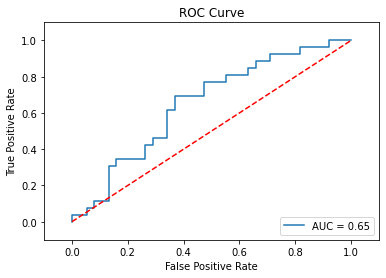

In [ ]:




# take the second column because the classifier outputs scores for
# the 0 class as well


# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(label_test_all.detach().cpu().numpy(), outputs_test_all[:,1].detach().cpu().numpy())

auc_score = metrics.auc(fpr, tpr)

# clear current figure


plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

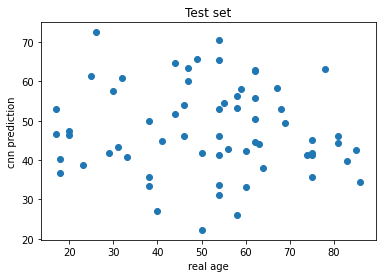

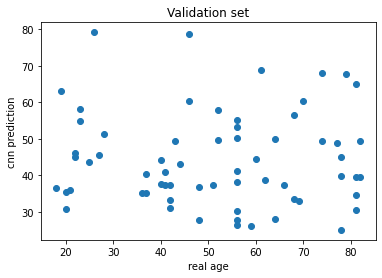

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


age_net = age_net.to(device, non_blocking=True)
age_net.eval()

outputs_test_all = []
label_test_all = []
outputs_val_all = []
label_val_all = []


for i, test_data in enumerate(test_dataloader_age,0):

            inputs_test, labels_test = test_data
            inputs_test = inputs_test.to(device, non_blocking=True, dtype=torch.float)
            labels_test = labels_test.to(device, non_blocking=True, dtype=torch.float)
            inputs_test = inputs_test.permute(0,2,1)
            outputs_test = age_net(inputs_test)
            outputs_test_all.append(outputs_test)
            label_test_all.append(labels_test)

outputs_test_all = torch.cat(outputs_test_all,dim = 0)
label_test_all = torch.cat(label_test_all,dim = 0).detach().cpu().numpy()

pred_test_age = outputs_test_all.detach().cpu().numpy()
pred_test_age[np.isnan(label_test_all)]=np.nan
#label_test_all[np.isnan(label_test_all)]=0
plt.figure()
plt.scatter(label_test_all, pred_test_age.squeeze())
plt.title('Test set')
plt.xlabel('real age')
plt.ylabel('cnn prediction')
plt.show()

for i, val_data in enumerate(val_dataloader_age,0):

            inputs_val, labels_val = val_data
            inputs_val = inputs_val.to(device, non_blocking=True, dtype=torch.float)
            labels_val = labels_val.to(device, non_blocking=True, dtype=torch.float)
            inputs_val = inputs_val.permute(0,2,1)
            outputs_val = age_net(inputs_val)
            outputs_val_all.append(outputs_val)
            label_val_all.append(labels_val)

outputs_val_all = torch.cat(outputs_val_all,dim = 0)


label_val_all = torch.cat(label_val_all,dim = 0).detach().cpu().numpy()
pred_val_age = outputs_val_all.detach().cpu().numpy()
pred_val_age[np.isnan(label_val_all)]=np.nan
# label_val_all[np.isnan(label_val_all)]=0
plt.figure()
plt.scatter(label_val_all, pred_val_age)
plt.title('Validation set')
plt.xlabel('real age')
plt.ylabel('cnn prediction')
plt.show()


# data = {'A': [45,37,42,35,39],
#         'B': [38,31,26,28,33],
#         'C': [10,15,17,21,12]
#         }

# df = pd.DataFrame(data,columns=['A','B','C'])

# corrMatrix = df.corr()
# sn.heatmap(corrMatrix, annot=True)
# plt.show()

In [ ]:
# torch.cuda.empty_cache()   
